# The 2-Min-Cut Problem

Given any multigraph, we can partition its vertices into two sets. Such a partition leaves edges that cross from one set into the other. Those crossing edges shall be called the cut edges, or simply the cut. There are, of course, many cuts but we seek  the minimum. The question is: how does one partition a graph so as to minimize the number of edges in a cut? Correspondingly, with weighted edges, how does one minimize the sum of weights for a cut? For thinking about problems involving graph cuts like this I've found it useful to think of cuts akin to string figure games, like [cat's cradle](http://fun-party-games.com/cats-cradle.htm), where the hands can pull vertices apart into two sections and the edges between the sets hang between the fingers.
![cats cradle](http://upload.wikimedia.org/wikipedia/commons/d/de/Cats-cradle.svg "the strings between are the cut edges")

## Karger's Contraction Method

In 1992, David Karger introduced the probabilistic contraction method for finding min-cuts in his paper [*Global Min-cuts in RNC*](http://dl.acm.org/citation.cfm?id=313605). His algorithm proceeds as follows: until only two *meta-*vertices remain, pick an edge uniformly at random and merge the two incident vertices of the edge. The motivation is simple: evident merely by the title *minimum cut*, the number of edges within any min-cut is likely to be small. Hence, there should be a high probability that after many contractions, edges in the minimum cut were not contracted. Specifically, to contract an edge $(u, v)$ create a new vertex $w$ and define its neighbors to be the multiset sum of of $u$ and $v$'s neighbors. Except in that sum we do not include edges between $u$ and $v$, in order to remove self-loops. See, that meta-vertices formed from contraction become the partition of the original vertices. In the figure below, [Thore Hysfeldt](http://thorehusfeldt.net/2012/09/07/images-for-kargers-algorithm/) has made some illustrative contractions: 
![contraciton examples](http://upload.wikimedia.org/wikipedia/commons/e/e7/Single_run_of_Karger%E2%80%99s_Mincut_algorithm.svg "Thore Husfeldt's contraction examples")

In the text to follow, I make extensive use of insight from Karger's latter 1996 paper [*A New Approach to the Minimum Cut Problem*](http://www.columbia.edu/~cs2035/courses/ieor6614.S09/Contraction.pdf). I found it quite helpful in understanding all aspects of the algorithm and its generalizations. Let us now prove the claim that with high probability, the no edges in a min-cut will be contracted. For now we assume that the graph is unweighted. The weighted case will follow quite simply afterward. First, suppose that the minimum size cut has $c$ edge crossings. There may be many cuts that have this size, but we look only at one without loss of generality. When contracting the graph, we will come to a point where only $k$ vertices remain. The min-cut size of this contracted graph must be at least $c$ by the definition of the original min-cut. So, the minimum degree of the graph with $k$ vertices is $c$. Thus, the graph will have at least $kc/2$ edges. But, only $c$ of those edges are part of the minimum cut. Hence, the probability of choosing a min-cut edge in the contraction is $2/k$. Now, we make $n - 2$ contractions, for an original graph of size $n$, until just 2 meta-vertices or partitioned sets remain. Each contraction reduces the number of edges in the graph by 1. So, the probability that no min-cut edges are contracted in the whole run of the algorithm is:

$$\left(1 - \frac{2}{n}\right)\left(1 - \frac{2}{n-1}\right)\cdots\left(1 - \frac{2}{3}\right) = \binom{n}{2}^{-1} = \Omega(n^{-2})$$ 

And there it is! That's a pretty good bound. And if we repeat the algorithm a bunch of times, say like $2\binom{n}{2}\ln(n)$ times then the probability of incorrectly contracting at least one min-cut edge every time is bounded as such:

$$\left(1-\binom{n}{2}^{-1}\right)^{\binom{n}{2}\cdot2\ln(n)} \leq e^{-2\ln(n)} = \frac{1}{n^2}$$

Now, to apply this to weighted graphs see that we can map the weights to a number of parallel edges. In this construction, the probability of contracting one of those parallel edges is proportional to the weight of the original edge—and the contract of one of those parallel edges has the same effect as contraction for the weighted edge. So the uniform picking simply turns into a weighted picking of edges.

## Implementing Karger's Algorithm

Now, let's roughly implement this algorithm, such that we can use it on a distance matrix that represents how related any two indices are. Although the algorithm's description is quite simple, the actual implementation of it is a bit tricky. Particularly, the contraction bit. The input for our algorithm will be a distance matrix, and to contract we will push on vertex onto another, instead of creating a new vertex. This can be done by adding both the row and column of one vertex onto the other. This makes sense, as any weights represented in a column or row correspond directly to incident edges; and we want to move those incidences from one vertex to another.

First, though, let's create a weighted choice method to aid a contraction function:

In [1]:
from itertools import accumulate
from bisect import bisect
from random import random

def wchoice(ws):
    cumdist = list(accumulate(ws))
    x = cumdist[-1] * random()
    return bisect(cumdist, x)

Now, let's test it out to make sure it works. I've found the Python package [tabulate](https://pypi.python.org/pypi/tabulate) to be a little bit more easy to play around with than panda's DataFrame method for simple examples and quick checking. As a side note, see the changes for Python 3 below: first `range` has [replaced](http://stackoverflow.com/questions/15014310/why-is-there-no-xrange-function-in-python3) `xrange`; and second, as per [PEP 238](http://legacy.python.org/dev/peps/pep-0238/), (`/`) is reserved for float division now.

In [2]:
from collections import Counter
from tabulate import tabulate

ws = [0.1, 0.2, 0.3, 0.4]
trials = 10**5
c = Counter(wchoice(ws) for _ in range(trials))    # only Count a generator instead of a list to save memory
rfreqs = [(k, round(v/trials, 4)) for k, v in c.items()]
print(tabulate(rfreqs, headers=['index', 'rel. freq.']))

  index    rel. freq.
-------  ------------
      0        0.1014
      1        0.1993
      2        0.3007
      3        0.3987


 Now, it may be the case that there are no edges connecting two vertices in the distance matrix. If this is the case then when `wchoice` returns an index from the weights list referrring to that index of non-zero weights in the upper triangular matrix. Because there are possibly irregular zero values, those non-zero edges' indices must be stored ahead of time, such that we can return the index for the choice. Thus, there would be two passes through the upper indices, once to store indices of the edges and thier weights, and then another to calculate the weighted choice. That method, however, also requires $o(n^2)$ memory. Another option, is to run through only once, applying the king of the hill weighted choice method. As Eli Bendersky [points out](http://eli.thegreenplace.net/2010/01/22/weighted-random-generation-in-python/) in a blog post this method can be applied to a stream of incoming weights, where we may not know how many non-zero entries there are. This is exactly the kind of weighted choice that we seek; although it has the draw back of being a bit slower. Let's quickly implement it. Also it will help to define an upper triangular index generator for a matrix.

In [3]:
import numpy as np

def utri(n, offset=1):
    '''Generates tuples of indices i, j for the upper triangular portion of an n x n matrix.
    The offset dicates how far the columns should start counting after the diagonal: offset=0.
    '''
    for i in range(n):
        for j in range(i + offset, n):
            yield i, j
            
# example distance matrix
dm = np.array([[0, .1, 0, 0],
               [.1, 0, .2, .4],
               [0, .2, 0, .3],
               [0, .4, .3, 0]])

def king_hill(dm):
    total = 0
    for i, j in utri(len(dm)):
        w = dm[i, j]
        if w > 0:
            total += w
            if random() * total < w:
                winner = i, j
    return winner

# we perform another quick check on the correctness of this weighted choice
trials = 10**5
c = Counter(king_hill(dm) for _ in range(trials))
rfreqs = [(str(k), v/trials) for k, v in c.items()]
rfreqs = sorted(rfreqs, key=lambda e: e[1])
print(tabulate(rfreqs, headers=['index', 'rel. freq.']))

index      rel. freq.
-------  ------------
(0, 1)        0.09886
(1, 2)        0.19879
(2, 3)        0.30006
(1, 3)        0.40229


Now let's create the `contract` method and `karger` method. Here's how they'll work: `contract` will take in a distance matrix, randomly pick an edge wrt the weights and contract them. It will then return the row and column of its edge selection, and return the new contracted distance matrix. The method `karger` will also take in a distance matrix, and runs the `contract` method until only 2 meta-vertices remain. It accumulates the selected edges returned by `contract`, so as to keep track of the cut's partition of the vertices. This whole process will be run $q\binom{n}{2}\ln{n}$ many times, where $q$ the exponent to get an error rate of $n^{-q}$ by the analysis above. For all these trials it will keep track of the most minimum cut weight, and return the minimum found with the corresponding partition of the indices. We can do more than just this though, Karger's implementation will actually return all min-cuts with high probability. Furthermore, if this method was used to divide objects into maximally different sets, where the distance matrix represented similarities between objects, then it may be the case that some choice will want to be done on the available cuts. That is, although a cut might have minimum value, there may be some conditions put onto the partition itself, such that the second minimum cut will actually work better. For all these reasons we implement the method with a heap, and then return the top $n$ cuts values along with one representative partition.

In [4]:
from math import log
import heapq
            
def contract(dm):
    n = dm.shape[0]
    total = 0
    winner = None
    for i, j in utri(n):
        w = dm[i, j]
        if w > 0:
            total += w
            if random() * total < w:
                winner = i, j
    i, j = winner
    dm[i,:] += dm[j,:]
    dm[:,i] += dm[j,:]        # reference dm[j,:] not dm[:,j] as the latter might have changed
    dm[i,i] = 0
    dm[j,:] = np.zeros(n)
    dm[:,j] = np.zeros(n)
    return (i, j), dm

def karger(dm, q=2, topn=3):
    n = dm.shape[0]
    trials = int(n*(n-1)/2 * q * log(n))        # yields Omega(n^-q) error, with exponent q
    heap = []
    cuts = {}
    for _ in range(trials):
        dmc = np.copy(dm)
        part = set()        # temp variable for cut set
        for _ in range(n - 2):
            ix, dmc = contract(dmc)
            i, j = ix
            if i in part or j in part or len(part) == 0:        # add i, j to appropriate partition
                part.add(i), part.add(j)
        cut_weight = np.sum(dmc)/2        # only count edge weights once
        if frozenset(part) not in cuts:
            heapq.heappush(heap, (cut_weight, part))
            cuts[frozenset(part)] = (cut_weight, part)
    return heapq.nsmallest(topn, heap)

We could test this algorithm via a brute force approach, but see that it would entail finding all partitions into 2 sets. The problem of finding all partitions into $r$ parts is a difficult one. Knuth covers it in TAOCP Vol. 4: *Combinatorial Algorithms*, specifically [sections 7.2.1.4-5](http://www.cs.utsa.edu/~wagner/knuth/). For now, however, we shall relay the partition topic and the algorithm testing to [another notebook](http://www.google.com). From that notebook, though, we call non-empty subsets that define a partition of a set *blocks*. And from here on out, that is what they shall explicitly called.

# The $k$-Min-Cut Problem

The contraction method described above can also be adapted for any $r$-cut in general. If we stop the contraction until $r$ meta-vertices remain then it turns out that, again, we have have a high probability of never cutting min-cut edges. And that's exactly what we want. As a side note, the cat's cradle analogy works for general $r$-cuts as well, all you need are other friend's hands: ![r-cut cat's cradle](http://youthvoices.net/sites/default/files/image/55246/oct/cats-cradle-8.png "4-cut simulated by 4 hands in cat's cradle")

## Generalizing the contraction method

First, just to clarify once more, the probabilistic analysis to follow has been learned from Karger's [*A New Approach to the Minimum Cut Problem*](http://www.columbia.edu/~cs2035/courses/ieor6614.S09/Contraction.pdf). Now to prove the contraction can be stopped early to generate a $r$ min-cut with high probability, let's first find the probability that a randomly picked edge from a graph with $n$ vertices is a min-cut edge. We use the probabilistic method, and construct a scenario where the probability of picking an edge in the min cut is clear: suppose we pick $r - 1$ vertices uniformly at random to create $r - 1$ singleton blocks with the remaining vertices defining the $r$<sup>th</sup> block. In this way we have defined an $r$-cut. Since an edge is in the cut if its vertices are in different blocks, then with this constuction an edges is in the cut if one of its vertices is in one of the $r - 1$ singleton blocks. This is simply the compliment of the chance that both of its vertices aren't in the $r - 1$ singleton blocks: 

$$1 - (1 - \frac{r - 1}{n})(1 - \frac{r - 1}{n - 1})$$ 

Next, we can now calculate the probability that a cut edge is never contracted. As calculated before, the probability of not picking a min-cut edge with $u$ edges is simply $(1 - \frac{r - 1}{u})(1 - \frac{r - 1}{u - 1})$. If we stop short with $r$ vertices remaining, each contraction reducing the size of the graph by one, then we will finally contract with a graph of size $r + 1$. The probability of never picking an edge from the cut set is then: 

$$ \eqalign{\prod_{u = r + 1}^n{ (1 - \frac{r - 1}{u})(1 - \frac{r - 1}{u - 1}) } &= \\ &= \prod_{u = r + 1}^n{ (1 - \frac{r - 1}{u}) }\prod_{u = r + 1}^n{ (1 - \frac{r - 1}{u - 1}) } &= \\ &= r\binom{n}{r-1}^{-1}\binom{n-1}{r-1}^{-1} \\ &= \Omega(n^{-2(r-1)})}$$

And there you have it. So, we can easily change the previous karger method to accommodate this; the best part being that the contraction method is exactly the same! Most of the change will occur with how the blocks are handled. When contracting an edge, to decide which block to put it in, we will keep a list of all pre-existing blocks. If the incident vertices of that edge are in a particular block then add it to that block, or if there aren't any blocks then create a first block. As we are trying to keep a heap, however, it will be cumbersome to check set existence in the dictionary for more than $r=2$ blocks. So, instead, let's have the algorithm just output restricted growth strings. This format is more heavily discussed in the notebook pertaining to the partition problem, [linked here](http://www.google.com) as before.

In [5]:
def karger2(dm, r, q=2, topn=3):
    dm = np.array(dm)
    n = len(dm)
    trials = int(n*(n-1)/2 * q * log(n))        # yields Omega(n^-q) error, with exponent q
    heap = []
    cuts = {}
    for _ in range(trials):
        dmc = np.copy(dm)
        rgs = [None] * n        # current restriced growth string
        group = 0
        for _ in range(n - r):
            ix, dmc = contract(dmc)
            i, j = ix
            if rgs[i] == None and rgs[j] == None:
                rgs[i] = group; rgs[j] = group
                group += 1
            elif rgs[i] != None:
                rgs[j] = rgs[i]
            elif rgs[j] != None:        # we use elif for clarity, but they both can't be None by construction
                rgs[i] = rgs[j]
        cut_weight = np.sum(dmc)/2        # only count edge weights once
        for i in range(n):
            if rgs[i] == None:        # assign remaining ungroup vertices
                rgs[i] = group
                group += 1
        if tuple(rgs) not in cuts:
            heapq.heappush(heap, (cut_weight, rgs))
            cuts[tuple(rgs)] = (cut_weight, rgs)
    return heapq.nsmallest(topn, heap)

# Visualizing Cuts

Let's also create an easy way to visualize the cuts that the algorithm produces. 

0.0


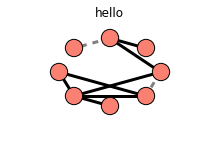

In [16]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def get_cut(dm, part):
    n = len(dm)
    cut = set()
    for i in range(0, n):
        for j in range(i+1, n):
            if dm[i, j] > 0 and (i in part) ^ (j in part):        # python xor
                cut.add((i, j))
    return cut

# example distance matrix
dm = np.random.rand(8, 8)
for (i, j), x in np.ndenumerate(dm):
    if random() < 0.8:
        dm[i, j] = 0

cut_weight, part = karger(dm)[0]
cut = get_cut(dm, part)
G = nx.from_numpy_matrix(dm)
ecolors = ['gray' if e in cut else 'k' for e in G.edges()]
estyles = ['dashed' if e in cut else 'solid' for e in G.edges()]
plt.subplot(221)
plt.title('hello')
nx.draw_shell(G, node_color='salmon', edge_color=ecolors, width = 3, style=estyles)

print(cut_weight)